In [11]:
%cd ~/dev/event-camera/src

/home/gianscarpe/dev/event-camera/src


In [12]:
from experimenting.dataset import get_dataloader, DHPJointsDataset, DHP3DJointsDataset
from experimenting.dataset.params_utils import get_dataset_params
from matplotlib import pyplot as plt
import numpy as np
from albumentations import Compose, CenterCrop
from albumentations.pytorch import ToTensor
import torch
from importlib import reload  
from experimenting.models import metrics, losses

from omegaconf import DictConfig

from experimenting.utils import get_file_paths, plot_heatmap, plot_skeleton_3d, denormalize_predict
import numpy as np

%matplotlib inline

In [27]:
aug = Compose([CenterCrop(256, 256), ToTensor()])
data_dir = '/data/dhp19/time_count_dataset/movements_per_frame'
labels_dir = "/data/dhp19/time_count_dataset/labels_full_joints/"
exp_dir = '/home/gianscarpe/dev/exps/timecount_pose/exps_MargiPoseModel'
test_subjects = [1, 2, 3, 4, 5]
cams = [3]

batch_size = 16

hparams = DictConfig({'data_dir': data_dir, 'save_split':False, 'labels_dir' :
                      labels_dir, 'test_subjects':test_subjects, 'split_at':0.8, 'cams': cams})

In [28]:
params = get_dataset_params(hparams)
d = DHP3DJointsDataset(file_paths = params['file_paths'], labels_dir =
                       labels_dir, indexes=params['test_indexes'], transform=aug)
loader = get_dataloader(d, batch_size, 2)

.npy|.mat


In [16]:
batch = next(iter(loader))
x, y = batch

 # Eval margipose model

In [25]:
import glob

In [44]:
exps = sorted(glob.glob(os.path.join(exp_dir,'exp*')))
print(list(exps))

['/home/gianscarpe/dev/exps/timecount_pose/exps_MargiPoseModel/exp_Adam_0.0003_center_crop_06-16-10-20', '/home/gianscarpe/dev/exps/timecount_pose/exps_MargiPoseModel/exp_Adam_0.0003_center_crop_06-17-09-33']


In [55]:
import experimenting.models as models
import os
import experimenting.models.metrics as metrics
import experimenting.models.losses as losses
from experimenting.utils import get_joints_from_heatmap, average_loss, decompose_projection_matrix, plot_skeleton_3d
import experimenting.utils.cv_helpers as utils


exp_name = exps[-1]
checkpoint_dir = os.path.join(exp_name, 'checkpoints')
checkpoints = sorted(os.listdir(checkpoint_dir))
checkpoint_path = os.path.join(checkpoint_dir, checkpoints[0])
model = models.MargiposeEstimator.load_from_checkpoint(checkpoint_path)
model = model.cpu()

In [56]:
# Load matrix
homedir = '/data/dhp19'
P_mat_dir = os.path.join(homedir, 'P_matrices/')
P_mat_cam3 = np.load(os.path.join(P_mat_dir,'P2.npy'))
M,_ = decompose_projection_matrix(P_mat_cam3)


XY GT


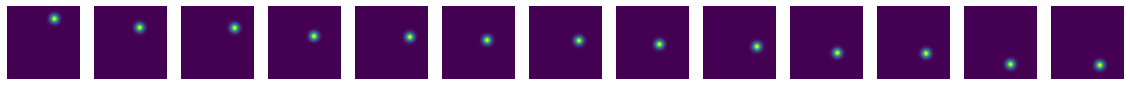

PRED XY


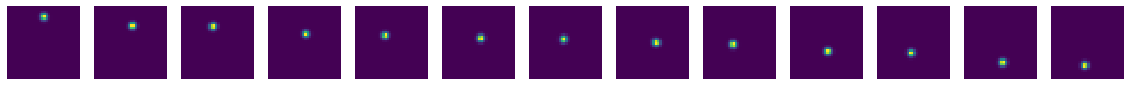

PRED ZY


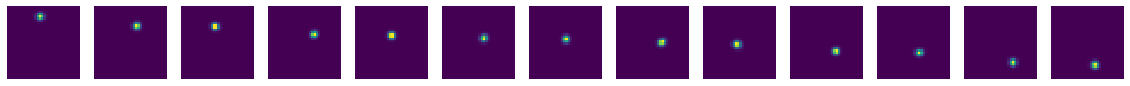

PRED XZ


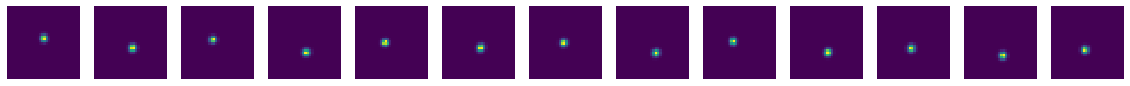

In [57]:
idx = 0

y_sample = np.load(d.labels[d.x_indexes[0]])
x_sample, _ = d[idx]

with torch.no_grad():
    preds = model(x_sample.unsqueeze(0))

#plt.imshow(x_sample.squeeze())
# HM gt
print("XY GT")
hms = utils.get_heatmap(y_sample['joints'].swapaxes(1, 0), y_sample['mask'], 256, 256, 13)
plot_heatmap(hms.swapaxes(-1, 0))

# XY
print("PRED XY")
plot_heatmap(preds[0][-1][0])

# ZY
print("PRED ZY")
plot_heatmap(preds[1][-1][0])

# XZ
print("PRED XZ")
plot_heatmap(preds[2][-1][0])



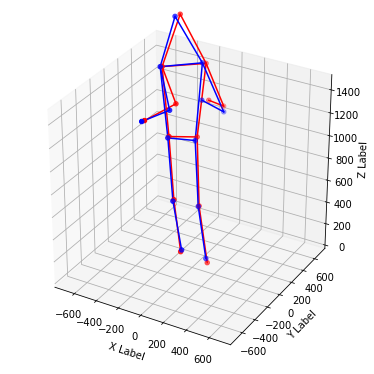

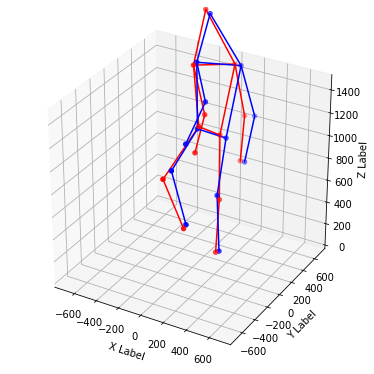

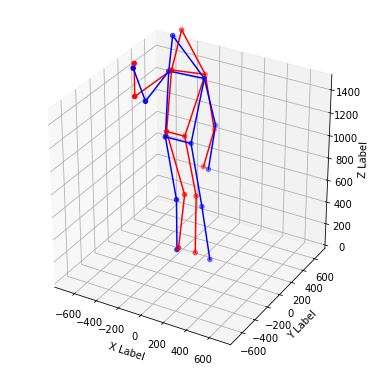

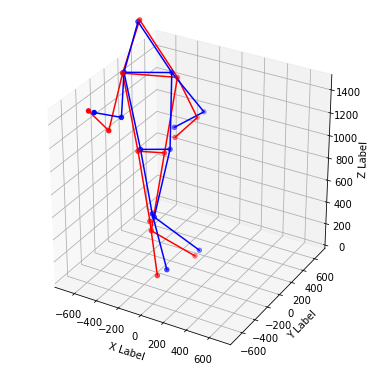

In [60]:
with torch.no_grad():
    preds = model(x.cpu())
    normalized_skeletons = model.predict3d(preds)
    
for i in range(4):
    camera = y['camera'][i]
    gt_skeleton = y['skeleton'][i].numpy().swapaxes(1, 0)
    pred_skeleton = normalized_skeletons[i].narrow(-1, 0, 3)
    pred_skeleton = utils.denormalize_predict(pred_skeleton,
                                        256, 256, camera)
    utils.plot_skeleton_3d(gt_skeleton, pred_skeleton, M)


# Test video 

In [56]:
import glob
import numpy as np
import h5py

In [61]:
root_dir = "/data/dhp19/time_count_dataset/346x260/"

x_paths = sorted(glob.glob(os.path.join(root_dir, "S1_*events.h5")))

In [63]:
x_h5 = h5py.File(x_paths[0], 'r')

In [67]:
frames = x_h5['DVS'][..., 2]

In [94]:
M, K = decompose_projection_matrix(P_mat_cam3)
K = torch.tensor(K)

In [98]:
with torch.no_grad():
    for i in range(len(frames)):
        f = frames[i] / 255.
        f = f.swapaxes(0, 1)
        augmented = aug(image=f)
        x = augmented['image'].unsqueeze(0).unsqueeze(0)

        preds = model(x.cpu())
        normalized_skeletons = model.predict3d(preds)

        pred_skeleton = normalized_skeletons[0].narrow(-1, 0, 3)
        pred_skeleton = utils.denormalize_predict(pred_skeleton,
                                                  256, 256, K)
        utils.plot_skeleton_3d(pred_skeleton, pred_skeleton, M)
        plt.savefig(f'test{i}.png')
        plt.close()


In [100]:
import cv2

In [ ]:
fe

In [ ]:
writer = cv2.VideoWriter("input.avi", cv2.VideoWriter_fourcc(*"MJPG"), 3,
                      (346, 260))
for im in frames:
        f = im.swapaxes(0, 1)
        f = np.expand_dims(f, -1)
        f = np.concatenate([f, f, f], axis=-1)
        writer.write(f.astype('uint8'))
writer.release()



In [ ]:
writer = cv2.VideoWriter("pred.avi", cv2.VideoWriter_fourcc(*"MJPG"), 3,
                         (360, 360))
images = sorted(glob.glob("*.png"))
for frame in images:
    im = cv2.imread(frame)
    writer.write(im.astype('uint8'))
writer.release()

